<a href="https://colab.research.google.com/github/tylee33/DLforFinance/blob/master/Fraud_Detection_with_Naive_Bayes_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,auc,roc_auc_score
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
# Data Handling: Load CSV
df = pd.read_csv("./creditcard.csv")

# get to know list of features, data shape, stat. description.
print(df.shape)

print("First 5 lines:")
print(df.head(5))

print("describe: ")
print(df.describe())

print("info: ")
print(df.info())

(284807, 31)
First 5 lines:
   Time        V1        V2        V3  ...       V27       V28  Amount  Class
0   0.0 -1.359807 -0.072781  2.536347  ...  0.133558 -0.021053  149.62      0
1   0.0  1.191857  0.266151  0.166480  ... -0.008983  0.014724    2.69      0
2   1.0 -1.358354 -1.340163  1.773209  ... -0.055353 -0.059752  378.66      0
3   1.0 -0.966272 -0.185226  1.792993  ...  0.062723  0.061458  123.50      0
4   2.0 -1.158233  0.877737  1.548718  ...  0.219422  0.215153   69.99      0

[5 rows x 31 columns]
describe: 
                Time            V1  ...         Amount          Class
count  284807.000000  2.848070e+05  ...  284807.000000  284807.000000
mean    94813.859575  3.919560e-15  ...      88.349619       0.001727
std     47488.145955  1.958696e+00  ...     250.120109       0.041527
min         0.000000 -5.640751e+01  ...       0.000000       0.000000
25%     54201.500000 -9.203734e-01  ...       5.600000       0.000000
50%     84692.000000  1.810880e-02  ...      22.00

Class as pie chart:


Text(0, 0.5, '')

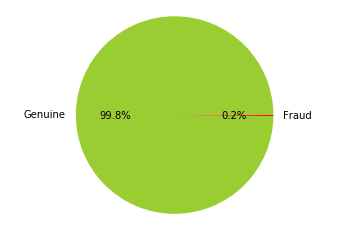

In [3]:
# Check Class variables that has 0 value for Genuine transactions and 1 for Fraud
print("Class as pie chart:")
fig, ax = plt.subplots(1, 1)
ax.pie(df.Class.value_counts(),autopct='%1.1f%%', labels=['Genuine','Fraud'], colors=['yellowgreen','r'])
plt.axis('equal')
plt.ylabel('')

Time variable
284802    47.996111
284803    47.996389
284804    47.996667
284805    47.996667
284806    47.997778
Name: Time_Hr, dtype: float64


Text(0, 0.5, '# transactions')

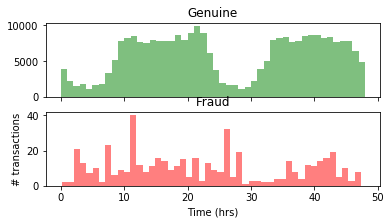

In [4]:
#plot Time to see if there is any trend
print("Time variable")
df["Time_Hr"] = df["Time"]/3600 # convert to hours
print(df["Time_Hr"].tail(5))
fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True, figsize=(6,3))
ax1.hist(df.Time_Hr[df.Class==0],bins=48,color='g',alpha=0.5)
ax1.set_title('Genuine')
ax2.hist(df.Time_Hr[df.Class==1],bins=48,color='r',alpha=0.5)
ax2.set_title('Fraud')
plt.xlabel('Time (hrs)')
plt.ylabel('# transactions')

This "Time" feature shows that rate of transactions is picking up during day time. But number of transactions have almost similar dependence on time of the day for both the classes. So, I believe this feature does not yield any predictive power to distinguish between the two classes. But ofcourse I will later test this assumption. For now, I'll keep this feature in data frame. I will drop "Time" but keep "Time_Hr".

In [0]:
df = df.drop(['Time'],axis=1)

Text(0, 0.5, '# transactions')

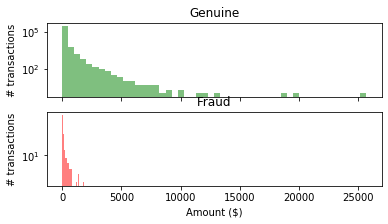

In [6]:
#let us check another feature Amount
fig, (ax3,ax4) = plt.subplots(2,1, figsize = (6,3), sharex = True)
ax3.hist(df.Amount[df.Class==0],bins=50,color='g',alpha=0.5)
ax3.set_yscale('log') # to see the tails
ax3.set_title('Genuine') # to see the tails
ax3.set_ylabel('# transactions')
ax4.hist(df.Amount[df.Class==1],bins=50,color='r',alpha=0.5)
ax4.set_yscale('log') # to see the tails
ax4.set_title('Fraud') # to see the tails
ax4.set_xlabel('Amount ($)')
ax4.set_ylabel('# transactions')

interesting to note "all transaction amounts > 10K in Genuine Class only". Also this amount feature is not on same scale as principle components. So, I'll standardize the values of the 'Amount' feature using StandardScalar and save in data-frame for later use.

In [0]:
from sklearn.preprocessing import StandardScaler
df['scaled_Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1,1))
df = df.drop(['Amount'],axis=1)

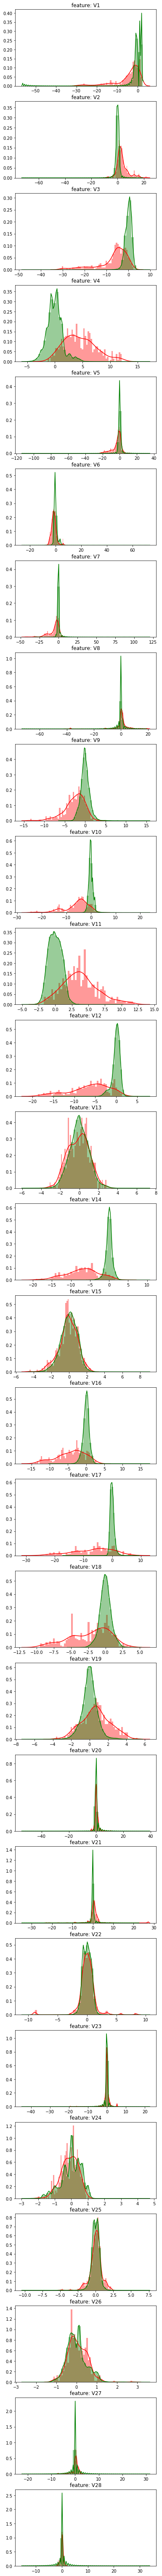

In [8]:
#let us check correlations and shapes of those 25 principal components.
# Features V1, V2, ... V28 are the principal components obtained with PCA.
import seaborn as sns
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(28, 1)
plt.figure(figsize=(6,28*4))
for i, col in enumerate(df[df.iloc[:,0:28].columns]):
    ax5 = plt.subplot(gs[i])
    sns.distplot(df[col][df.Class == 1], bins=50, color='r')
    sns.distplot(df[col][df.Class == 0], bins=50, color='g')
    ax5.set_xlabel('')
    ax5.set_title('feature: ' + str(col))
plt.show()

For some of the features, both the classes have similar distribution. So, I don't expect them to contribute towards classifying power of the model. So, it's best to drop them and reduce the model complexity, and hence the chances of overfitting. Ofcourse as with my other assumptions, I will later check the validity of above argument.

Now, it's time to split the data in test set (20%) and training set (80%). I'll define a function for it.

In [0]:
def split_data(df, drop_list):
    df = df.drop(drop_list,axis=1)
    print(df.columns)
    #test train split time
    from sklearn.model_selection import train_test_split
    y = df['Class'].values #target
    X = df.drop(['Class'],axis=1).values #features
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42, stratify=y)

    print("train-set size: ", len(y_train),
      "\ntest-set size: ", len(y_test))
    print("fraud cases in test-set: ", sum(y_test))
    return X_train, X_test, y_train, y_test

Below is funtion to define classifier and get predictions. We can use "predict()" method that checks whether a record should belong to "Fraud" or "Genuine" class. There is another method "predict_proba()" that gives the probabilities for each class. It helps us to learn the idea of changing the threshold that assigns an instance to class 1 or 0, thus we can control precision and recall scores. This would be used to calculate area under ROC.

In [0]:
def get_predictions(clf, X_train, y_train, X_test):
    # create classifier
    clf = clf
    # fit it to training data
    clf.fit(X_train,y_train)
    # predict using test data
    y_pred = clf.predict(X_test)
    # Compute predicted probabilities: y_pred_prob
    y_pred_prob = clf.predict_proba(X_test)
    #for fun: train-set predictions
    train_pred = clf.predict(X_train)
    print('train-set confusion matrix:\n', confusion_matrix(y_train,train_pred)) 
    return y_pred, y_pred_prob

Function to print the classifier's scores

In [0]:
def print_scores(y_test,y_pred,y_pred_prob):
    print('test-set confusion matrix:\n', confusion_matrix(y_test,y_pred)) 
    print("recall score: ", recall_score(y_test,y_pred))
    print("precision score: ", precision_score(y_test,y_pred))
    print("f1 score: ", f1_score(y_test,y_pred))
    print("accuracy score: ", accuracy_score(y_test,y_pred))
    print("ROC AUC: {}".format(roc_auc_score(y_test, y_pred_prob[:,1])))

As I discussed above, some of features have very similar shapes for the two types of transactions, so I belive that dropping them should help to reduce the model complexity and thus increase the classifier sensitivity.

Let us check this with dropping some of the features and checking scores.

In [0]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

In [13]:
# Case-NB-1 : do not drop anything
drop_list = []
X_train, X_test, y_train, y_test = split_data(df, drop_list)
y_pred, y_pred_prob = get_predictions(GaussianNB(), X_train, y_train, X_test)
print_scores(y_test,y_pred,y_pred_prob)

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Class', 'Time_Hr',
       'scaled_Amount'],
      dtype='object')
train-set size:  227845 
test-set size:  56962
fraud cases in test-set:  98
train-set confusion matrix:
 [[222480   4971]
 [    69    325]]
test-set confusion matrix:
 [[55535  1329]
 [   15    83]]
recall score:  0.8469387755102041
precision score:  0.058781869688385266
f1 score:  0.10993377483443707
accuracy score:  0.9764053228468101
ROC AUC: 0.963247971529636


In [14]:
# Case-NB-2 : drop some of principle components that have similar distributions in above plots 
drop_list = ['V28','V27','V26','V25','V24','V23','V22','V20','V15','V13','V8']
X_train, X_test, y_train, y_test = split_data(df, drop_list)
y_pred, y_pred_prob = get_predictions(GaussianNB(), X_train, y_train, X_test)
print_scores(y_test,y_pred,y_pred_prob)

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V11', 'V12',
       'V14', 'V16', 'V17', 'V18', 'V19', 'V21', 'Class', 'Time_Hr',
       'scaled_Amount'],
      dtype='object')
train-set size:  227845 
test-set size:  56962
fraud cases in test-set:  98
train-set confusion matrix:
 [[223967   3484]
 [    61    333]]
test-set confusion matrix:
 [[55935   929]
 [   12    86]]
recall score:  0.8775510204081632
precision score:  0.08472906403940887
f1 score:  0.15453728661275834
accuracy score:  0.9834802148800955
ROC AUC: 0.9622034097825962


Clearly, by removing some of the reduntant principle components, I gain in model sensitivity and precision.

In [15]:
# Case-NB-3 : drop some of principle components + Time 
drop_list = ['Time_Hr','V28','V27','V26','V25','V24','V23','V22','V20','V15','V13','V8']
X_train, X_test, y_train, y_test = split_data(df, drop_list)
y_pred, y_pred_prob = get_predictions(GaussianNB(), X_train, y_train, X_test)
print_scores(y_test,y_pred,y_pred_prob)

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V11', 'V12',
       'V14', 'V16', 'V17', 'V18', 'V19', 'V21', 'Class', 'scaled_Amount'],
      dtype='object')
train-set size:  227845 
test-set size:  56962
fraud cases in test-set:  98
train-set confusion matrix:
 [[223964   3487]
 [    60    334]]
test-set confusion matrix:
 [[55936   928]
 [   12    86]]
recall score:  0.8775510204081632
precision score:  0.08481262327416174
f1 score:  0.15467625899280577
accuracy score:  0.9834977704434535
ROC AUC: 0.9613612643988377


As we can see by comapring Case-NB-3 scores with Case-NB-2 scores, "Time_Hr" is not helping much in classification. So, I can remove it safely.

In [16]:
# Case-NB-4 : drop some of principle components + Time + 'scaled_Amount'
drop_list = ['scaled_Amount','Time_Hr','V28','V27','V26','V25','V24','V23','V22','V20','V15','V13','V8']
X_train, X_test, y_train, y_test = split_data(df, drop_list)
y_pred, y_pred_prob = get_predictions(GaussianNB(), X_train, y_train, X_test)
print_scores(y_test,y_pred,y_pred_prob)

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V11', 'V12',
       'V14', 'V16', 'V17', 'V18', 'V19', 'V21', 'Class'],
      dtype='object')
train-set size:  227845 
test-set size:  56962
fraud cases in test-set:  98
train-set confusion matrix:
 [[224025   3426]
 [    60    334]]
test-set confusion matrix:
 [[55954   910]
 [   12    86]]
recall score:  0.8775510204081632
precision score:  0.08634538152610442
f1 score:  0.15722120658135283
accuracy score:  0.9838137705838981
ROC AUC: 0.9611556179872063


I would say, Case-NB-4 gives me better model sensitivity (or recall) and precision as compared to Case-NB-1. So dropping some of redundant feature will ofcourse helps to make calculations fast and gain senstivity.

In [17]:
df = df.drop(drop_list,axis=1)
print(df.columns)

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V11', 'V12',
       'V14', 'V16', 'V17', 'V18', 'V19', 'V21', 'Class'],
      dtype='object')


Let us now do the predictions with another classifier: logistic regression

My aim is to compare the performance i.e. recall score of GaussianNB() with recall score of logistic regressor for test dataset (which is 20% of full dataset, selected above).

I'll start with running

* default logistic regressor
* for full imbalanced dataset (I know it is a bad approach, but this is just to get rough estimate)
  - that has been splitted into train-test subsets (80:20),  case-4 above.

In [20]:
# let us check recall score for logistic regression
# Case-LR-1
y_pred, y_pred_prob = get_predictions(LogisticRegression(C = 0.01, penalty = 'l2'), X_train, y_train, X_test)
print_scores(y_test,y_pred,y_pred_prob)

train-set confusion matrix:
 [[227427     24]
 [   153    241]]
test-set confusion matrix:
 [[56851    13]
 [   39    59]]
recall score:  0.6020408163265306
precision score:  0.8194444444444444
f1 score:  0.6941176470588234
accuracy score:  0.9990871107053826
ROC AUC: 0.9725212608960297


As we see, by learning from full imbalanced dataset this default logistic regressor performs very poorly. So let us try to train it in tradional way i.e. from under-sampled data. So, take only that percent of genuine-class cases which is equal to all fraud-classes i.e. consider 50/50 ratio of both classes.

In [21]:
# get indices for fraud and genuine classes 
fraud_ind = np.array(df[df.Class == 1].index)
gen_ind = df[df.Class == 0].index
n_fraud = len(df[df.Class == 1])
# random selection from genuine class
random_gen_ind = np.random.choice(gen_ind, n_fraud, replace = False)
random_gen_ind = np.array(random_gen_ind)
# merge two class indices: random genuine + original fraud
under_sample_ind = np.concatenate([fraud_ind,random_gen_ind])
# Under sample dataset
undersample_df = df.iloc[under_sample_ind,:]
y_undersample  = undersample_df['Class'].values #target
X_undersample = undersample_df.drop(['Class'],axis=1).values #features

print("# transactions in undersampled data: ", len(undersample_df))
print("% genuine transactions: ",len(undersample_df[undersample_df.Class == 0])/len(undersample_df))
print("% fraud transactions: ", sum(y_undersample)/len(undersample_df))

# transactions in undersampled data:  984
% genuine transactions:  0.5
% fraud transactions:  0.5


In [23]:
# let us train logistic regression with undersamples data
# Case-LR-2
# split undersampled data into 80/20 train-test datasets. 
# - Train model from this 80% fraction of undersampled data, get predictions from left over i.e. 20%.
drop_list = []
X_und_train, X_und_test, y_und_train, y_und_test = split_data(undersample_df, drop_list)
y_und_pred, y_und_pred_prob = get_predictions(LogisticRegression(C = 0.01, penalty = 'l2'), X_und_train, y_und_train, X_und_test)
print_scores(y_und_test,y_und_pred,y_und_pred_prob)

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V11', 'V12',
       'V14', 'V16', 'V17', 'V18', 'V19', 'V21', 'Class'],
      dtype='object')
train-set size:  787 
test-set size:  197
fraud cases in test-set:  98
train-set confusion matrix:
 [[386   7]
 [ 52 342]]
test-set confusion matrix:
 [[97  2]
 [ 6 92]]
recall score:  0.9387755102040817
precision score:  0.9787234042553191
f1 score:  0.9583333333333333
accuracy score:  0.9593908629441624
ROC AUC: 0.9847454133168418


As per expectations, wonderfull performance for completely balanced classes.

Now, let us check its performance for the full skewed dataset. Just to mention: "train" from undersampled data, and "test" on full data.

In [25]:
# Case-LR-3
# "train" with undersamples, "test" with full data
# call classifier
lr = LogisticRegression(C = 0.01, penalty = 'l2')
# fit it to complete undersampled data
lr.fit(X_undersample, y_undersample)
# predict on full data
y_full = df['Class'].values #target
X_full = df.drop(['Class'],axis=1).values #features
y_full_pred = lr.predict(X_full)
# Compute predicted probabilities: y_pred_prob
y_full_pred_prob = lr.predict_proba(X_full)
print("scores for Full set")   
print('test-set confusion matrix:\n', confusion_matrix(y_full,y_full_pred)) 
print("recall score: ", recall_score(y_full,y_full_pred))
print("precision score: ", precision_score(y_full,y_full_pred))

scores for Full set
test-set confusion matrix:
 [[281207   3108]
 [    59    433]]
recall score:  0.8800813008130082
precision score:  0.12228184128777182


I just want to compare the scores from GaussianNB with logistic-regression.

* get predictions for test-dataset (20% of full dataset) from both models.

Aim is to compare recall score of Case-NB-4 with Case-LR-4.

In [26]:
# Case-LR-4
y_p20_pred = lr.predict(X_test)
y_p20_pred_prob = lr.predict_proba(X_test)
print("scores for test (20% of full) set")   
print('test-set confusion matrix:\n', confusion_matrix(y_test,y_p20_pred)) 
print("recall score: ", recall_score(y_test,y_p20_pred))
print("precision score: ", precision_score(y_test,y_p20_pred))

scores for test (20% of full) set
test-set confusion matrix:
 [[56217   647]
 [   10    88]]
recall score:  0.8979591836734694
precision score:  0.11972789115646258


Conclusions: Nodoubt, LR gives better model sensitivity, but positive predictive value for NB is more than double (although low for both). As said in introduction, Naive-Bayes is just simple prob. calculator, no coeff. optimization by fitting etc. , so this is quick learner. We can hopefully improve NB's performance by playing around with default threshold on calculated probabilities, but still 89% of fraud cases are detected, bravo NB!